# Problem Set #7
## MACS30150, Dr. Evans
### Yongfei Lu    Feb. 21st, 2020
### Problem 1
#### (a)

In [2]:
import pandas as pd
df = pd.read_csv('data/strongdrink.txt')
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

X = df[['alco', 'malic', 'tot_phen', 'color_int']]
y = df["cultivar"]
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size = 0.25,random_state=20)
res = LogisticRegression(solver='lbfgs',multi_class=\
                            'multinomial').fit(X_train, y_train)

pd.DataFrame({"j = 1": np.append(res.intercept_[0],res.coef_[0]),
             "j = 2": np.append(res.intercept_[1],res.coef_[1])},
            index=["beta_0", "beta_1",'beta_2','beta_3','beta_4'])


,j = 1,j = 2
beta_0,-24.027617,22.780733
beta_1,1.701734,-1.466297
beta_2,-0.265788,-0.332951
beta_3,1.224101,0.663556
beta_4,0.022507,-0.922682


In [13]:
y_pred = res.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [16]:
pd.DataFrame({"error_rate": [0.13, 0.0, 0.0]},
            index = ["j = 1", "j = 2", "j = 3"])

,error_rate
j = 1,0.13
j = 2,0.00
j = 3,0.00


Although the error rates of model j=2 and j=3 are equivalent,  model j=3 has the highest f1-socre and is the best at prediction, which is also the one with most observations.

In [17]:
MSE = np.mean((y_test != y_pred) ** 2)
print("Mean squared error is {}".format(MSE))

Mean squared error is 0.045454545454545456


### (b)

In [30]:
from sklearn.model_selection import LeaveOneOut

X_b=X.values
y_b=y.values
loo = LeaveOneOut()
loo.get_n_splits(X_b)
N_loo = X_b.shape[0]
MSE_vec = np.zeros(N_loo)

ytest = np.zeros(N_loo)
ypred = np.zeros(N_loo)

for train_index, test_index in loo.split(X_b):
    X_train, X_test = X_b[train_index], X_b[test_index]
    y_train, y_test = y_b[train_index], y_b[test_index]
    ytest[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1


MSE_loo = MSE_vec.mean()

print('LOOCV estimate for the test MSE mean as average MSE:', MSE_loo)


LOOCV estimate for the test MSE mean as average MSE: 0.07954545454545454


In [31]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



In [33]:
pd.DataFrame({"error_rate":[1 - 0.90, 1 - 0.91, 1 - 0.96]},
            index=["j = 1", "j = 2", "j = 3"])

,error_rate
j = 1,0.10
j = 2,0.09
j = 3,0.04


The error rates increase compared to those from part (a).

### (c)

In [38]:
k = 4
X_c = X.values
y_c = y.values
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(X_c)

MSE_vec_kf = np.zeros(k)
ytest = np.zeros(X_c.shape[0])
ypred = np.zeros(X_c.shape[0])
k_ind = int(0)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X_c[train_idx], X_c[test_idx]
    y_train, y_test = y_c[train_idx], y_c[test_idx]
    ytest[test_idx] = y_test

    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_idx] = y_pred

    n = len(y_pred)
    err=[1 if y_test[i] != y_pred[i] else 0 for i in range(n)]  
    MSE_vec_kf[k_ind]=np.mean(err)
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('test estimate MSE k-fold =', MSE_kf)


test estimate MSE k-fold = 0.09090909090909091


In [39]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



In [40]:
pd.DataFrame({"error_rate": [1-0.87, 1-0.91, 1-0.96]},
            index=["j = 1", "j = 2", "j = 3"])

,error_rate
j = 1,0.13
j = 2,0.09
j = 3,0.04


The error rates for j = 2,3  are the same with those from part (b), but increase compared to those from part (a). The error rate for j = 1 remain the same as that from part (a) but increase compared to that from part (b)

### Problem 2
#### (a)

In [90]:
import matplotlib.pyplot as plt

df2=pd.read_csv("data/CoolIndex.txt",names=["Age","Coolness"])
df2.head()

,Age,Coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


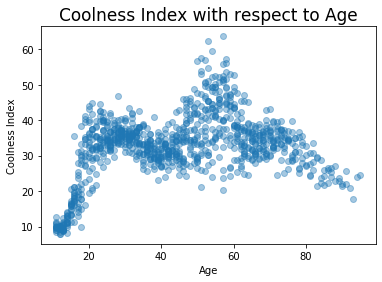

In [91]:
plt.scatter(df2['Age'],df2['Coolness'],alpha=0.4)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index with respect to Age", fontsize=17)
plt.show()

#### (b)


In [92]:
import statsmodels.api as sm

df2["bin1"] = np.where((df2.Age >= 11) & (df2.Age < 22), 1, 0)
df2["bin2"] = np.where((df2.Age >= 22) & (df2.Age < 40), 1, 0)
df2["bin3"] = np.where((df2.Age >= 40) & (df2.Age < 59), 1, 0)
df2["bin4"] = np.where((df2.Age >= 59) & (df2.Age < 77), 1, 0)
df2["bin5"] = np.where((df2.Age >= 77) & (df2.Age <= 95), 1, 0)

X_b = df2[["bin1", "bin2", "bin3", "bin4", "bin5"]]
y_b = df2['Coolness']
res = sm.OLS(y_b, X_b).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Fri, 21 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        15:09:17   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.000      18.999      21.206
bin2          34.4758      0.431     80.006      0.000      33.630      35.321
bin3          37.6351      0.424     88.814      0.000      36.804      38.467
bin4          35.2254      0.485     72.560      0.000      34.273      36.178
bin5          27.2964      0.936     29.175      0.000      25.460      29.132
==============================================================================
Omnibus:                       80.102   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.718
Skew:                           0.714   Prob(JB):                     8.17e-23
Kurtosis:                       3.719   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated step function values for each bin are 20.10, 34.48, 37.64, 35.23, 27.30 respectively.

In [73]:
cool = res.predict([0,0,0,1,0])
print("The predicted coolness of a 73-year old from the stepwise function is {}.".format(int(cool)))

The predicted coolness of a 73-year old from the stepwise function is 35.


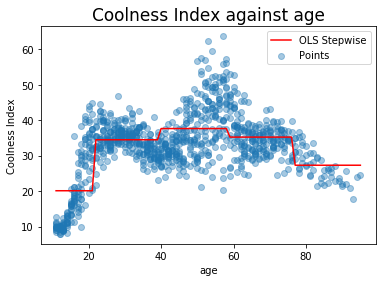

In [76]:
plt.scatter(df2.Age,df2.Coolness, alpha=0.4, label="Points")
plt.plot(df2.Age,res.predict(), color="r",label = "OLS Stepwise")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age", fontsize=17)
plt.show()

#### (c)

In [100]:
df2c = df2.groupby('Age').mean()
df2c['Age']=df2c.index
df2c[['Age','Coolness']].head()

,Age,Coolness
Age,,
11.0,11.0,10.110237
12.0,12.0,9.365623
13.0,13.0,10.015882
14.0,14.0,11.747109
15.0,15.0,15.434739


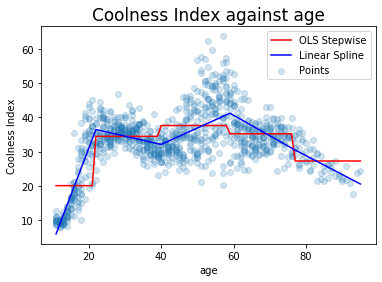

In [107]:
knots=[22,40,59,77]
ls=LSQUnivariateSpline(np.array(df2c.Age), np.array(df2c.Coolness), t=knots, k=1)

plt.scatter(df2.Age,df2.Coolness,alpha=0.2,label="Points")
plt.plot(df2.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df2c.Age,ls(df2c.Age),"b",label = "Linear Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age", fontsize=17)
plt.show()


In [113]:
age_c = ls(73)
print("The predicted coolness of a 73-year old from the cubic spline is {:.2f}".format(age_c))

The predicted coolness of a 73-year old from the cubic spline is 32.87


#### (d)

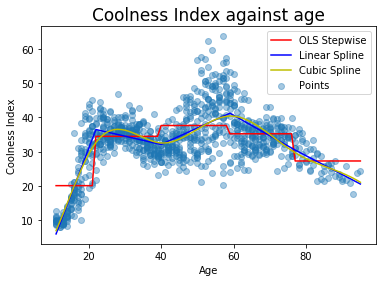

In [130]:
csp=LSQUnivariateSpline(np.array(df2c.Age), np.array(df2c.Coolness), t=knots, k=3)

plt.scatter(df2.Age,df2.Coolness,alpha=0.4,label="Points")
plt.plot(df2.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df2.Age,ls(df2.Age),"b",label = "Linear Spline")
plt.plot(df2c.Age,csp(df2c.Age),"y",label = "Cubic Spline")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age", fontsize=17)
plt.show()

In [132]:
age_d = csp(73)
print("The predicted coolness of a 73-year\
old from the cubic spline is {:.2f}".format(age_d))

The predicted coolness of a 73-yearold from the cubic spline is 32.64
